## Import packages

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy import integrate
import sys
import os
from ADFWI.propagator  import *
from ADFWI.model       import *
from ADFWI.view        import *
from ADFWI.utils       import *
from ADFWI.survey      import *
from ADFWI.fwi         import *

project_path = "/ailab/user/liufeng1/project/04_Inversion/ADFWI-github/examples/pip_usage/data"
if not os.path.exists(os.path.join(project_path,"model")):
    os.makedirs(os.path.join(project_path,"model"))
if not os.path.exists(os.path.join(project_path,"waveform")):
    os.makedirs(os.path.join(project_path,"waveform"))
if not os.path.exists(os.path.join(project_path,"survey")):
    os.makedirs(os.path.join(project_path,"survey"))
if not os.path.exists(os.path.join(project_path,"inversion")):
    os.makedirs(os.path.join(project_path,"inversion"))

## Define the basic model parameter

In [2]:
device = "cuda:0"         # Specify the GPU device
dtype = torch.float32     # Set data type to 32-bit floating point
ox, oz = 0, 0             # Origin coordinates for x and z directions
nz, nx = 88, 200          # Grid dimensions in z and x directions
dx, dz = 40, 40           # Grid spacing in x and z directions
nt, dt = 1600, 0.003      # Time steps and time interval
nabc = 30                 # Thickness of the absorbing boundary layer
f0 = 5                    # Initial frequency in Hz
free_surface = True       # Enable free surface boundary condition

## Define the initial velocity model

In [3]:
# Load the Marmousi model dataset from the specified directory.
marmousi_model = load_marmousi_model(in_dir="/ailab/user/liufeng1/project/04_Inversion/ADFWI-github/examples/datasets/marmousi2_source")


# Create coordinate arrays for x and z based on the grid size.
x = np.linspace(5000, 5000 + dx * nx, nx)
z = np.linspace(0, dz * nz, nz)
true_model = resample_marmousi_model(x, z, marmousi_model)
smooth_model = get_smooth_marmousi_model(true_model, gaussian_kernel=6)

# Initialize primary wave velocity (vp) and density (rho) for the model.
vp_init = smooth_model['vp'].T  # Transpose to match dimensions
rho_init = np.power(vp_init, 0.25) * 310  # Calculate density based on vp

# Extract true model properties for comparison.
vp_true = true_model['vp'].T  # Transpose for consistency
rho_true = np.power(vp_true, 0.25) * 310  # Calculate true density

model = AcousticModel(ox,oz,nx,nz,dx,dz,
                    vp_init,rho_init,
                    vp_bound=[vp_true.min(),vp_true.max()],
                    vp_grad=True,
                    free_surface=free_surface,
                    abc_type="PML",abc_jerjan_alpha=0.007,
                    nabc=nabc,
                    device=device,dtype=dtype)

# Save the initialized model to a file for later use.
model.save(os.path.join(project_path, "model/init_model.npz"))

# Print the model's representation for verification.
print(model.__repr__())

model with parameters ['vp', 'rho']:
  Model vp  :  1500.00 -  4146.96 m/s   , requires_grad = True, constrain bound: 1499.9999999 - 4777.700048035685
  Model rho :  1929.23 -  2487.68 kg/m^3, requires_grad = False, constrain bound: None - None
  Model orig: ox =   0.00, oz =   0.00 m
  Model grid: dx =  40.00, dz =  40.00 m
  Model dims: nx =    200, nz =     88
  Model size: 35200
  Free surface: True
  Absorbing layers: 30



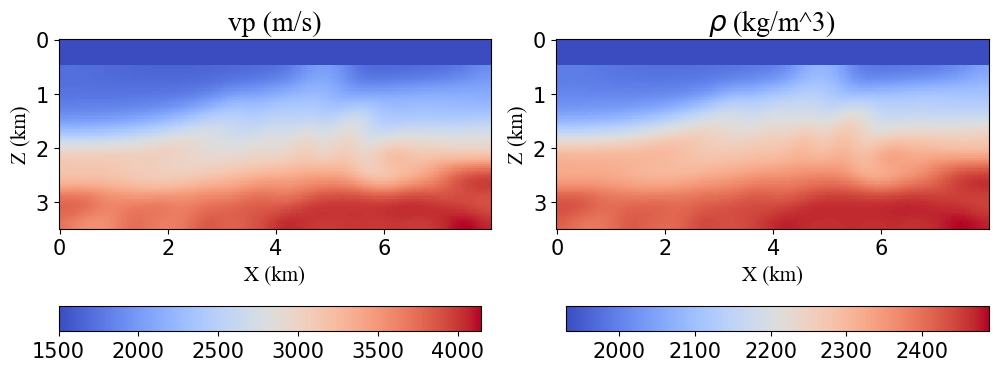

In [4]:
model._plot_vp_rho(figsize=(12,5),wspace=0.15,cbar_pad_fraction=0.01,cmap='coolwarm',save_path=os.path.join(project_path,"model/init_vp_rho.png"))

## Define the observed systems: Survey = Source + Receiver

In [5]:
# Define source positions in the model
src_z = np.array([1 for i in range(2, nx-1, 5)])  # Z-coordinates for sources
src_x = np.array([i for i in range(2, nx-1, 5)])  # X-coordinates for sources

# Generate wavelet for the source
src_t, src_v = wavelet(nt, dt, f0, amp0=1)  # Create time and wavelet amplitude
src_v = integrate.cumtrapz(src_v, axis=-1, initial=0)  # Integrate wavelet to get velocity

source = Source(nt=nt, dt=dt, f0=f0)  # Initialize source object

# Method 1: Add multiple sources at once (commented out)
# source.add_sources(src_x=src_x, src_z=src_z, src_wavelet=src_v, src_type='mt', src_mt=np.array([[1,0,0],[0,1,0],[0,0,1]]))

# Method 2: Loop through each source position to add them individually
for i in range(len(src_x)):
    source.add_source(src_x=src_x[i], src_z=src_z[i], src_wavelet=src_v, src_type="mt", src_mt=np.array([[1,0,0],[0,1,0],[0,0,1]]))


In [6]:
# Define receiver positions in the model
rcv_z = np.array([1 for i in range(0, nx, 1)])  # Z-coordinates for receivers
rcv_x = np.array([j for j in range(0, nx, 1)])  # X-coordinates for receivers

receiver = Receiver(nt=nt, dt=dt)  # Initialize receiver object

# Method 1: Add all receivers at once (commented out)
# receiver.add_receivers(rcv_x=rcv_x, rcv_z=rcv_z, rcv_type='pr')

# Method 2: Loop through each receiver position to add them individually
for i in range(len(rcv_x)):
    receiver.add_receiver(rcv_x=rcv_x[i], rcv_z=rcv_z[i], rcv_type="pr")

In [7]:
# Create a survey object using the defined source and receiver
survey = Survey(source=source, receiver=receiver)

# Print a representation of the survey object to check its configuration
print(survey.__repr__())

Survey Information:
Seismic Source:
  Source wavelet: 1600 samples at 3.00 ms
  Source number : 40
  Source types  : ['mt']
  Source x range: 2 - 197 (grids)
  Source z range: 1 - 1 (grids)

Seismic Receiver:
  Receiver data   : 1600 samples at 3.00 ms
  Receiver number : 200
  Receiver types  : ['pr']
  Receiver x range: 0 - 199 (grids)
  Receiver z range: 1 - 1 (grids)



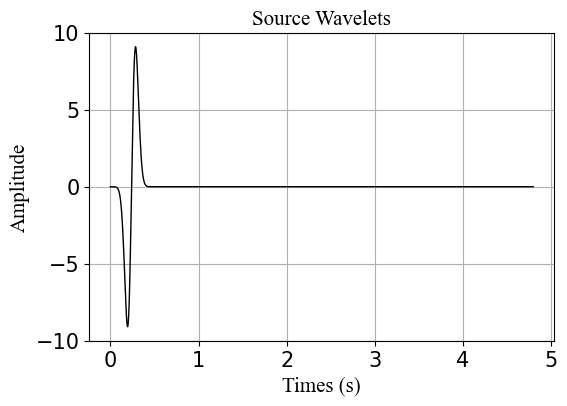

In [8]:
# Plot the wavelet used in the source
source.plot_wavelet(save_path=os.path.join(project_path, "survey/wavelets.png"))

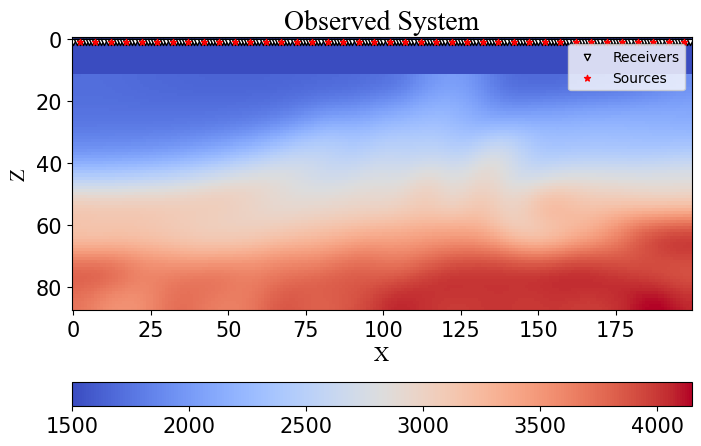

In [9]:
# Plot the survey configuration over the velocity model
survey.plot(model.vp,cmap='coolwarm',save_path=os.path.join(project_path,"survey/observed_system_init.png"))

## Define the propagator

In [10]:
# Initialize the wave propagator using the specified model and survey configuration
F = AcousticPropagator(model, survey, device=device)

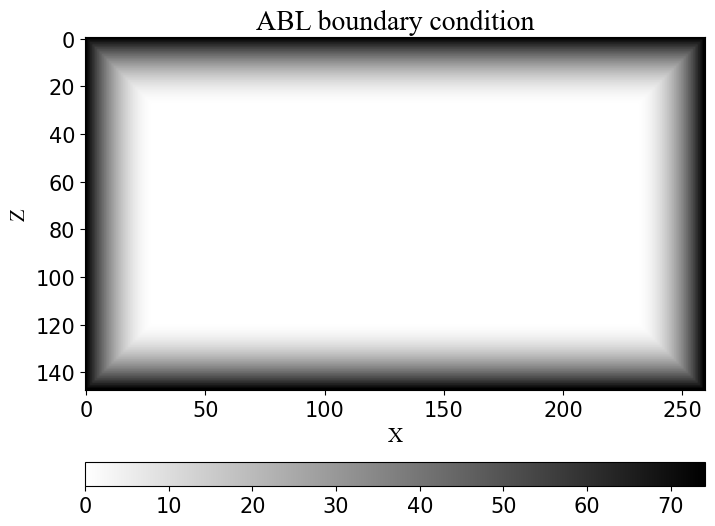

In [11]:
# Retrieve the damping array from the propagator and plot it to visualize boundary conditions
damp = F.damp
plot_damp(damp,save_path=os.path.join(project_path,"model/boundary_condition.png"))

## Load observed datasets

In [12]:
# Create an instance of SeismicData using the survey object.
d_obs = SeismicData(survey)

# Load observed waveform data from a specified file.
d_obs.load(os.path.join(project_path, "waveform/obs_data.npz"))

# Print a summary representation of the observed seismic data.
print(d_obs.__repr__())

Seismic Data:
  Source number : 40
  Receiver number : 200
  Time samples : 1600 samples at 3.00 ms



## Inversion

In [13]:
# Import the L2 misfit function for waveform inversion.
from ADFWI.fwi.misfit import Misfit_waveform_L2

# Set the number of iterations for the inversion process.
iteration = 10

# Initialize the optimizer (Adam) for model parameters with a learning rate.
optimizer = torch.optim.Adam(model.parameters(), lr=10)

# Set up a learning rate scheduler to adjust the learning rate over time.
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.75, last_epoch=-1)

# Configure the misfit function to compute the loss based on the observed data.
loss_fn = Misfit_waveform_L2(dt=dt)

# gradient processor
grad_mask = np.ones_like(vp_init)
grad_mask[:10,:] = 0
gradient_processor = GradProcessor(grad_mask=grad_mask)

# Initialize the acoustic full waveform inversion (FWI) object.
fwi = AcousticFWI(propagator=F,
                  model=model,
                  optimizer=optimizer,
                  scheduler=scheduler,
                  loss_fn=loss_fn,
                  obs_data=d_obs,
                  gradient_processor=gradient_processor,
                  waveform_normalize=True, 
                  cache_result=True,  
                  save_fig_epoch=50,  
                  save_fig_path=os.path.join(project_path, "inversion"))

# Run the forward modeling for the specified number of iterations.
fwi.forward(iteration=iteration, batch_size=None, checkpoint_segments=1)

# Retrieve the inversion results: updated velocity and loss values.
iter_vp = fwi.iter_vp
iter_loss = fwi.iter_loss

# Save the iteration results to files for later analysis.
np.savez(os.path.join(project_path, "inversion/iter_vp.npz"), data=np.array(iter_vp))
np.savez(os.path.join(project_path, "inversion/iter_loss.npz"), data=np.array(iter_loss))

## visualize the inverted results

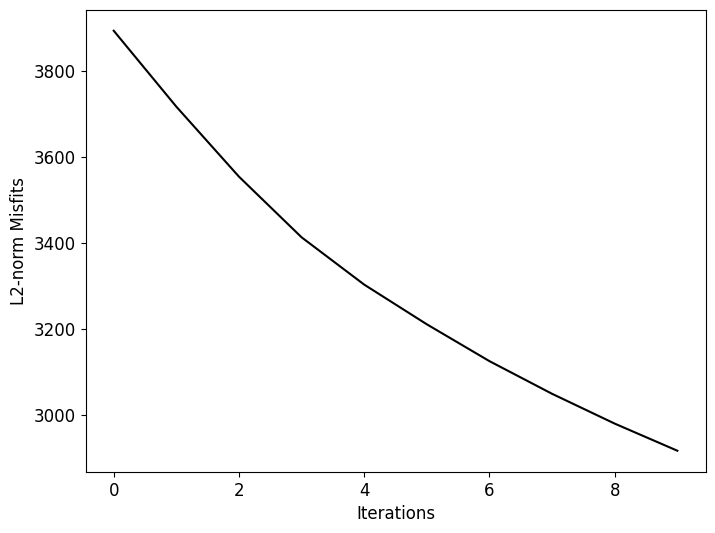

In [14]:
# plot the misfit
plt.figure(figsize=(8,6))
plt.plot(iter_loss,c='k')
plt.xlabel("Iterations", fontsize=12)
plt.ylabel("L2-norm Misfits", fontsize=12)
plt.tick_params(labelsize=12)
plt.savefig(os.path.join(project_path,"inversion/misfit.png"),bbox_inches='tight',dpi=100)
plt.show()

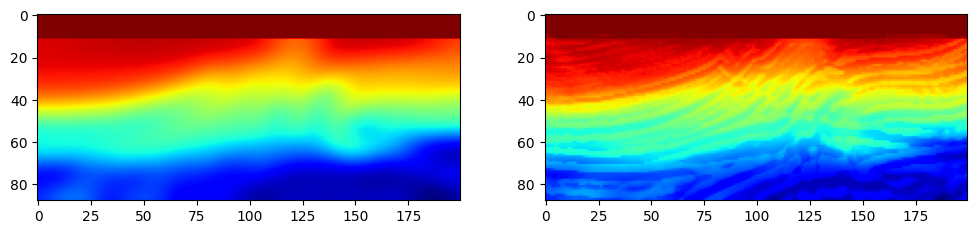

In [15]:
# plot the initial model and inverted resutls
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(vp_init,cmap='jet_r')
plt.subplot(122)
plt.imshow(iter_vp[-1],cmap='jet_r')
plt.savefig(os.path.join(project_path,"inversion/inverted_res.png"),bbox_inches='tight',dpi=100)
plt.show()

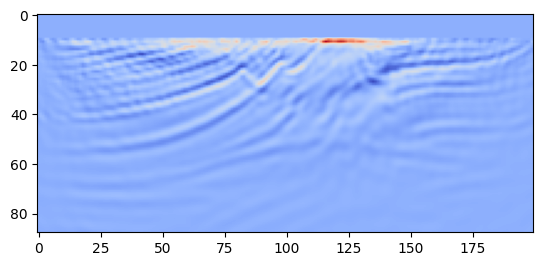

In [16]:
# plot the gradient
plt.figure()
plt.imshow(fwi.iter_vp_grad[0],cmap='coolwarm')
plt.show()

### Animation

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set up the figure for plotting
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(iter_vp[0], aspect='equal', cmap='jet_r', vmin=vp_true.min(), vmax=vp_true.max())
ax.set_title('Inversion Process Visualization')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Z Coordinate')

# Create a horizontal colorbar
cbar = fig.colorbar(cax, ax=ax, orientation='horizontal', fraction=0.046, pad=0.2)
cbar.set_label('Velocity (m/s)')

# Adjust the layout to minimize white space
plt.subplots_adjust(top=0.85, bottom=0.2, left=0.1, right=0.9)

# Initialization function
def init():
    cax.set_array(iter_vp[0])  # Use the 2D array directly
    return cax,

# Animation function
def animate(i):
    cax.set_array(iter_vp[i])  # Update with the i-th iteration directly
    return cax,

# Create the animation
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=len(iter_vp), interval=100, blit=True)

# Save the animation as a video file (e.g., MP4 format)
ani.save(os.path.join(project_path, "inversion/inversion_process.gif"), writer='pillow', fps=10)

# Display the animation using HTML
plt.close(fig)  # Prevents static display of the last frame
HTML(ani.to_jshtml())